## Loss

In [1]:
import matplotlib.pyplot as plt
from utils import Extractor

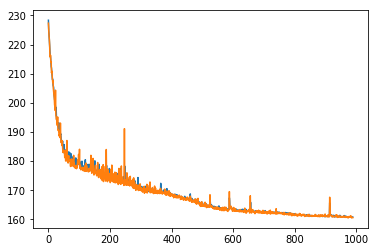

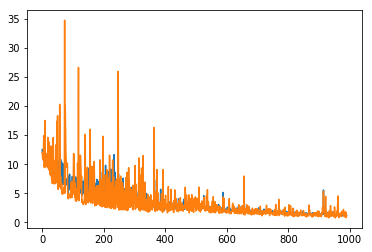

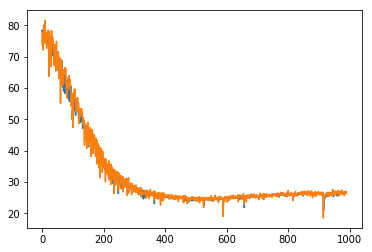

In [2]:
ext = Extractor("./logzero/Feb26_06-08-58.txt")

plt.plot(ext("train", "x_loss")[10:])
plt.plot(ext("test", "x_loss")[10:])
plt.show()
plt.plot(ext("train", "s_loss")[10:])
plt.plot(ext("test", "s_loss")[10:])
plt.show()
plt.plot(ext("train", "s_aux_loss")[10:])
plt.plot(ext("test", "s_aux_loss")[10:])
plt.show()

## Pred in env

In [1]:
import argparse
import os
import pickle
import sys
sys.path.append("../")
from model import SSM
from utils import load_model


parser = argparse.ArgumentParser()
parser.add_argument("--device", type=int, nargs="+", default=[0])
parser.add_argument("--s_dim", type=int, default=64)
parser.add_argument("--a_dim", type=int, default=6)
parser.add_argument("--o_dim", type=int, default=17)
parser.add_argument("--h_dim", type=int, default=128)
parser.add_argument("--timestamp", type=str, default=None)
parser.add_argument("--load_epoch", type=int, default=None)
args = parser.parse_args("\
    --device 0 \
    --timestamp Feb26_06-08-58 \
    --load_epoch 1000 \
    ".split())

model = SSM(args)
load_model(model, model_dir="./", epoch=args.load_epoch)

with open("../data/loop0/param.pkl", mode='rb') as f:
    a_mean, a_std, o_mean, o_std = pickle.load(f)

In [2]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlkit.envs.wrappers import NormalizedBoxEnv


env_name = 'HalfCheetah-v2'
# env = gym.make(env_name)
env = NormalizedBoxEnv(gym.make(env_name))

true = []
pred = []

o = env.reset()
o = o.astype(np.float32)
o = (o - o_mean) / o_std
o = torch.from_numpy(np.array([o]))
y = model.reset(o)

for t in range(300):
    # env.render()    
    a = env.action_space.sample()
    o, r, done, info = env.step(a)

    a = a.astype(np.float32)
    a = (a - a_mean) / a_std
    a = torch.from_numpy(np.array([a]))
    y = model.step(a)[0]
    y = y.cpu().detach().numpy()
    y = y * o_std + o_mean

    true.append(o)
    pred.append(y)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


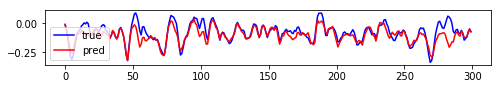

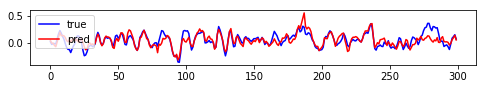

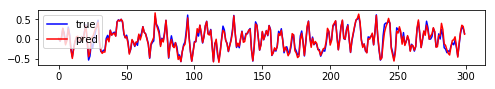

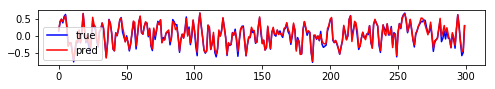

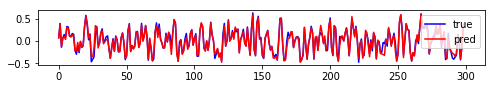

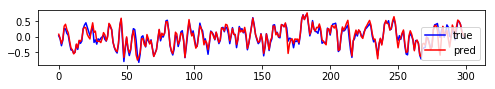

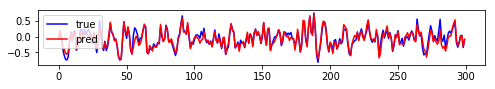

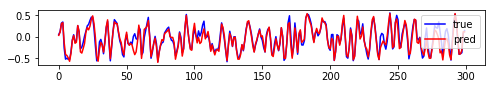

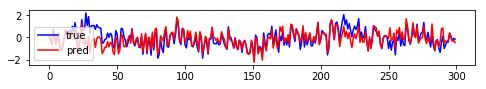

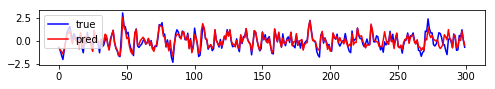

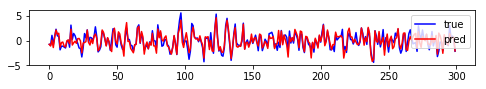

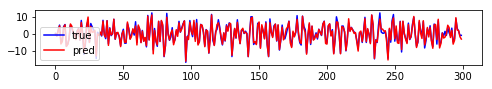

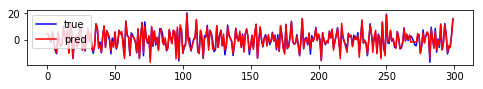

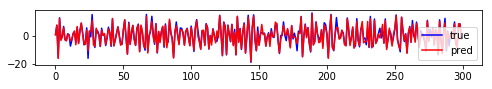

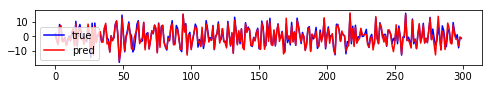

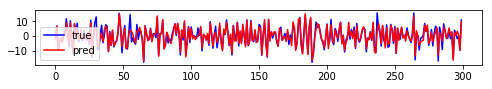

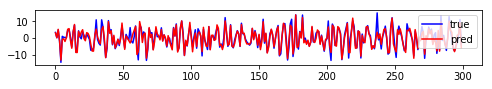

In [3]:
for k in range(len(pred[0])):
    plt.figure(figsize=(8,1))
    plt.plot(np.array(true)[:,k], c='b', label='true')
    plt.plot(np.array(pred)[:,k], c='r', label='pred')
    plt.legend()
    plt.show()

## Pred expert observation

- 四分位つける

In [1]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlkit.envs.wrappers import NormalizedBoxEnv

import argparse
import os
import pickle
import sys
sys.path.append("../")
from model import SSM
from utils import load_model


def eval_expert_loss(timestamp, load_epoch, param_path, data_path, show=False):
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", type=int, nargs="+", default=[0])
    parser.add_argument("--s_dim", type=int, default=64)
    parser.add_argument("--a_dim", type=int, default=6)
    parser.add_argument("--o_dim", type=int, default=17)
    parser.add_argument("--h_dim", type=int, default=128)
    parser.add_argument("--timestamp", type=str, default=None)
    parser.add_argument("--load_epoch", type=int, default=None)
    args = parser.parse_args("\
        --device 0 \
        --timestamp {} \
        --load_epoch {} \
        ".format(timestamp, load_epoch).split())

    model = SSM(args)
    load_model(model, model_dir="./", epoch=args.load_epoch)

    with open(param_path, mode='rb') as f:
        a_mean, a_std, o_mean, o_std = pickle.load(f)

    with open(data_path, mode='rb') as f:
        data = pickle.load(f)

    traj_a = np.array([data[i][0] for i in range(len(data))],
                      dtype=np.float32)
    traj_o = np.array([data[i][1] for i in range(len(data))],
                      dtype=np.float32)
    print(traj_a.shape, traj_o.shape)

    scores = []

    for trial in tqdm(range(100)):
        epis_a = traj_a[trial]
        epis_o = traj_o[trial]
        o, true = epis_o[0], epis_o[1:301]

        pred = []

        o = o.astype(np.float32)
        o = (o - o_mean) / o_std
        o = torch.from_numpy(np.array([o]))
        y = model.reset(o)

        for t in range(1, 301):
            a = epis_a[t]
            a = a.astype(np.float32)
            a = (a - a_mean) / a_std
            a = torch.from_numpy(np.array([a]))
            y = model.step(a)[0]
            y = y.cpu().detach().numpy()
            y = y * o_std + o_mean

            pred.append(y)

        if trial == 0 and show:
            for k in range(len(pred[0])):
                print(k)
                plt.figure(figsize=(12,1))
                plt.plot(np.array(true)[:,k], c='b', label='true')
                plt.plot(np.array(pred)[:,k], c='r', label='pred')
                plt.legend()
                plt.show()
    
    score = np.mean(np.sum(np.power(np.array(pred - true), 2), axis=1))
    scores.append(score)

    return np.mean(scores)

In [2]:
timestamp = "Feb26_06-08-58"
param_path = "../data/loop0/param.pkl"
data_path = "../diayn/data/expert.pkl"
scores = []

# score = eval_expert_loss(timestamp, 1000, param_path, data_path, show=True)
# print(score)

for i in range(5):
    score = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    scores.append(score)

  1%|          | 1/100 [00:00<00:12,  8.00it/s]

(100, 301, 6) (100, 301, 17)


  1%|          | 1/100 [00:00<00:11,  8.53it/s]

(100, 301, 6) (100, 301, 17)


  1%|          | 1/100 [00:00<00:11,  8.53it/s]

(100, 301, 6) (100, 301, 17)


  1%|          | 1/100 [00:00<00:12,  7.83it/s]

(100, 301, 6) (100, 301, 17)


  1%|          | 1/100 [00:00<00:11,  8.36it/s]

(100, 301, 6) (100, 301, 17)


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


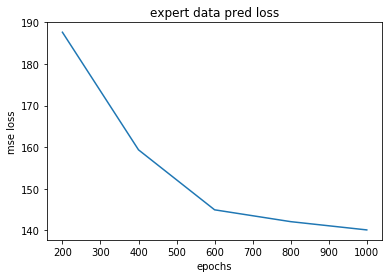

In [3]:
plt.plot([(i+1)*200 for i in  range(5)], scores)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

In [4]:
# random data
timestamp = "Feb26_06-08-58"
param_path = "../data/loop0/param.pkl"
data_path = "../data/loop0/test.pkl"

score = eval_expert_loss(timestamp, 1000, param_path, data_path)
print(score)

  1%|          | 1/100 [00:00<00:11,  8.73it/s]

(1000, 1000, 6) (1000, 1000, 17)


100%|██████████| 100/100 [00:12<00:00,  8.01it/s]

37.710045
